###  <center> Construção de uma GAN (Generative Adversarial Network) para gerar imagens do dataset <i>MNIST</i> </center>
- Autor: Edwin Jahir Rueda Rojas
- email: ejrueda95g@gmail.com
- github: https://github.com/ejrueda
- website: www.edwinrueda.com

### Resumen:
- É feita uma arquitetura GAN com os modelos sequenciais do <i><b>Keras</b></i>, pra isso, é implementada a classe <b>GANs</b> a qual têm tanto o gerador como o discriminador.

In [1]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

/home/ejrueda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
class GANs():
    #inialização dos parâmetros
    def __init__(self, width, height, channels, noise_input):
        self.width = width
        self.height = height
        self.channels = channels
        self.dim = (self.width, self.height, self.channels)
        self.noise_input = noise_input
        self.g_loss = []
        self.d_loss = []
        #self.optimizer = Adam(lr=0.0001, beta_1=0.5)
        self.optimizer = Adam(lr=0.0002, beta_1=0.5)
        #self.optimizer2 = Adam(lr=0.0001, beta_1=0.5)
        self.G = self.noise_generator()
        print("Compilando o gerador...")
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        self.D = self.discriminator()
        print("Compilando o discriminador...")
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        self.stacked_generator_discriminator = self.__stacked_generator_discriminator()
        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        
    #criação do gerador de imagens fake
    def noise_generator(self):
        model = Sequential()#256, 512, 1024
        model.add(Dense(128, input_shape=(self.noise_input,)))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(BatchNormalization(momentum=0.8)) #normalización de las capas anteriores
        model.add(Dense(256))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.width  * self.height * self.channels, activation='tanh'))
        model.add(Reshape((self.width, self.height, self.channels)))
        return model
    
    #criação do discriminador
    def discriminator(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.dim))
        model.add(Dense((self.width * self.height * self.channels), input_shape=self.dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.int64((self.width * self.height * self.channels)/2)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        return model

    #Para unir el generador y el disctiminador
    def __stacked_generator_discriminator(self):
        self.D.trainable = False
        model = Sequential()
        model.add(self.G)
        model.add(self.D)
        return model
    
    #Para obter o sumary do gerador
    def summary_gerador(self):
        return self.G.summary()
    
    #Para obter o sumary do gerador
    def summary_discriminador(self):
        return self.D.summary()
        
    #pra obter os batches pra o treino
    def get_batches(self, X_train, batch_size):
        """
        X_train: dataset para o treino
        epochs: quantidade de epocas para o treino do gradiente
        batch: tamanho to batch pra o treino de cada epochs
        """
        batches = []
        num_bat = int(np.ceil(X_train.shape[0]/batch_size))
        lim_i = 0
        lim_s = batch_size
        for i in range(num_bat):
            if lim_s > X_train.shape[0]:
                lim_s = X_train.shape[0]
            batches.append(X_train[lim_i:lim_s])
            lim_i += batch_size
            lim_s += batch_size
            
        return batches
        
    #devolve o loss do gerador e do discriminador
    def get_loss(self):
        return [self.g_loss, self.d_loss]
    
    #treinamento da GAN
    def train(self, X_train, epochs, batch_size):
        self.d_loss = []
        self.g_loss = []
        for cnt in range(epochs):
            batches = obj_gan.get_batches(X_train, batch_size)
            count_b = 1
            for batch in batches:
                gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), self.noise_input))
                #gerando as imagens fake 
                syntetic_images = self.G.predict(gen_noise)
                #criação do array de treinamento
                x_combined_batch = np.concatenate((batch, syntetic_images))
                y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                                   np.zeros((batch.shape[0], 1))))
                #treino do discriminador
                d_l = self.D.train_on_batch(x_combined_batch, y_combined_batch)
                self.d_loss.append(d_l[0])

                # train generator
                noise = np.random.normal(0, 1, (batch.shape[0], self.noise_input))
                y_mislabled = np.ones((batch.shape[0], 1))

                g_l = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)
                self.g_loss.append(g_l)
                
                print ('epoch:[%d/%d] batch:[%d/%d], [Discriminator :: d_loss: %f], [Generator :: loss: %f]'
                       % (cnt+1,epochs,count_b,len(batches),d_l[0],g_l))
                count_b += 1
    #gerar imagens novas
    def predict(self, noise):
        return self.G.predict(noise)

### Treinamento:
- As imagens do MNIST têm uma qualidade de (28,28,1), sendo em escalas de cinza.
- O <i>noise_input</i> é o array de 200 gerado á partir de uma distribuição normal, pra que o <b>gerador</b> possa gerar as imagens fake.

In [7]:
obj_gan = GANs(width=28,height=28,channels=1,noise_input=200)

Compilando o gerador...
Compilando o discriminador...


In [8]:
(X_train,_),(_,_) = mnist.load_data()
m = 255/2
X_train = (X_train - m)/m
X_train = np.expand_dims(X_train, axis=3)

In [ ]:
t_i = time()
obj_gan.train(X_train,epochs=60,batch_size=32)
t_f = time()
print("------------------------------------------")
print("tempo de execução: ", (t_f-t_i)/60, "[min]")

In [44]:
print("tempo de execução do treinamento da rede: ", (t_f-t_i)/60, "[min]")

tempo de execução do treinamento da rede:  57.947152535120644 [min]


-- Imagens geradas pelo Gerador da GAN --


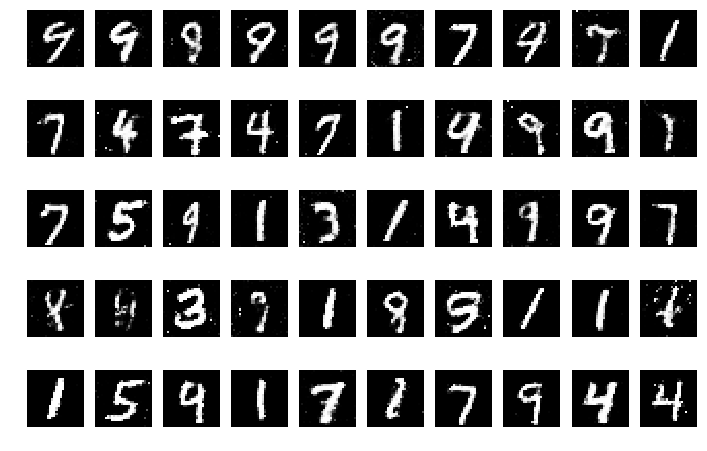

In [26]:
num_imgs = 50 #número de imágenes a mostrar aleatoriamente
x = np.random.normal(0,1,(num_imgs,200))
img_pre = obj_gan.predict(x)
fig = plt.figure(figsize=(12,8))
print("-- Imagens geradas pelo Gerador da GAN --")
for i in range(num_imgs):
    ax=fig.add_subplot(5,10,i+1)
    plt.imshow(img_pre[i].reshape(28,28), cmap = plt.cm.Greys_r)
    ax.axis("off")

In [27]:
sum(img_pre[5].reshape(28,28)**2)

array([27.352032, 27.192123, 26.070606, 25.611074, 26.205736, 27.366419,
       25.736712, 23.40655 , 24.492056, 23.328085, 24.223133, 22.62956 ,
       20.586363, 19.461872, 20.266546, 18.580574, 22.168877, 19.06348 ,
       25.340965, 25.246105, 27.428062, 27.079216, 27.622982, 25.942022,
       26.814812, 27.108337, 27.110323, 26.40019 ], dtype=float32)

In [28]:
a = (img_pre[2].reshape(28,28)/np.sqrt(np.sum(img_pre[2].reshape(28,28)**2)))
b = (img_pre[1].reshape(28,28)/np.sqrt(np.sum(img_pre[1].reshape(28,28)**2)))

In [29]:
print("similaridade")
sum(np.ravel(a*b))

similaridade


0.8723291383730043

In [30]:
print("------------------- Summary do gerador -------------------")
obj_gan.summary_gerador()

------------------- Summary do gerador -------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               25728     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
dense_10 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_6 (Le

In [31]:
print("------------------- Summary do discriminador -------------------")
obj_gan.summary_discriminador()

------------------- Summary do discriminador -------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 784)               615440    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 392)               307720    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 392)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 393       
Total params: 1,847,106
Trainable params: 923,553
Non-trainable params: 923,5

/home/ejrueda/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


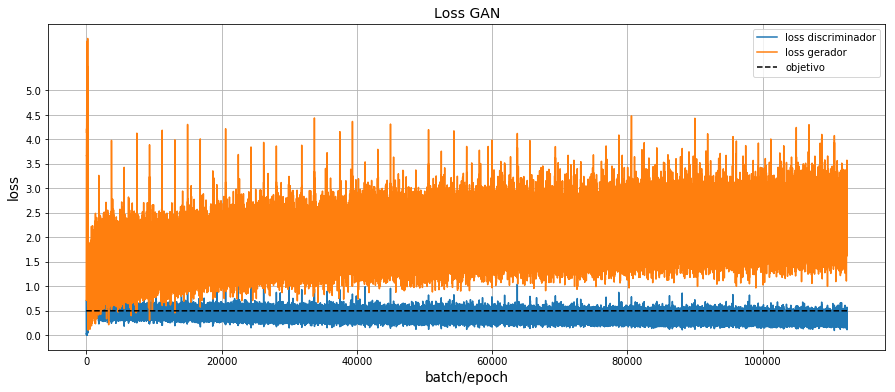

In [32]:
g_loss, d_loss = obj_gan.get_loss()

plt.figure(figsize=(15,6))
#plt.plot(range(len(g_loss)), g_loss)
plt.title("Loss GAN", fontsize=14)
plt.ylabel("loss", fontsize=13.5)
plt.xlabel("batch/epoch", fontsize=13.5)
plt.plot(range(np.array(d_loss).shape[0]), np.array(d_loss), label="loss discriminador")
plt.plot(range(np.array(g_loss).shape[0]), np.array(g_loss), label="loss gerador")
plt.plot(range(np.array(g_loss).shape[0]), 0.5*np.ones(np.array(g_loss).shape[0]),
         color="black", label="objetivo", linestyle='--')
plt.grid()
plt.yticks([0, 0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])
plt.legend();

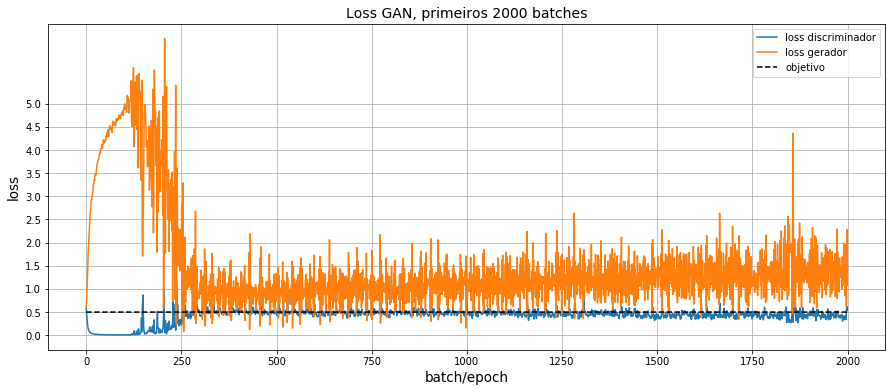

In [259]:
g_loss, d_loss = obj_gan.get_loss()

num_r = 2000
plt.figure(figsize=(15,6))
#plt.plot(range(len(g_loss)), g_loss)
plt.title("Loss GAN, primeiros " + str(num_r) + " batches", fontsize=14)
plt.ylabel("loss", fontsize=13.5)
plt.xlabel("batch/epoch", fontsize=13.5)
plt.plot(range(num_r), np.array(d_loss)[:num_r], label="loss discriminador")
plt.plot(range(num_r), np.array(g_loss)[:num_r], label="loss gerador")
plt.plot(range(num_r), 0.5*np.ones(num_r),
         color="black", label="objetivo", linestyle='--')
plt.grid()
plt.yticks([0, 0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])
plt.legend();

In [75]:
#gerando as imagens fake
fake_img = obj_gan.G.predict(np.random.normal(size=(1000,200)))
#criação do array de treinamento
x_combined_batch = np.concatenate((X_train[:1000], fake_img))
y_combined_batch = np.concatenate((np.ones((1000, 1)),
                                   np.zeros((1000, 1))))
#treino do discriminador
loss, accu = obj_gan.D.train_on_batch(x_combined_batch, y_combined_batch)

/home/ejrueda/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
